## 1. Import Library

In [20]:
# === Library Dasar Python ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle
import os

# === Library untuk Pemodelan & Machine Learning ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

# === Library untuk Evaluasi Model ===
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# === Library untuk Hyperparameter Tuning ===
import optuna

# === Library untuk Penanganan Data Imbalanced ===
from imblearn.over_sampling import SMOTE

# === Library untuk Dataset Eksternal ===
from datasets import load_dataset

## 2. Data Understanding

In [7]:
ds = load_dataset("m2s6a8/diabetes_prediction_dataset")
data = pd.DataFrame(ds['train'])

### 2.1 Mengetahui Ringkasan Statistik dari Data

In [8]:
data.describe(include='all')

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,3,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,Female,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN
freq,58552,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN
mean,NaN,41.885856,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000
std,NaN,22.516840,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883
min,NaN,0.080000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000
25%,NaN,24.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000
50%,NaN,43.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000
75%,NaN,60.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000


**Penjelasan :**

Berdasarkan deksripsi statistik dari data yang diperoleh, terlihat bahwa dataset berjumlah 100.000 observasi. Terdapat 9 variabel pada dataset yang digunakan. Variabel kategorik yang digunakan adalah gender (Jenis Kelamin) dan smoking_history (Riwayat Merokok). Berdasarkan data yang diberikan terdapat 3 nilai pada variabel gender, yaitu Male, Female, dan Other. Pada variabel smoking_history terdaapt 6 nilai bertipe nominal. 

Pada variabel numerik terdapat 7 variabel seperti age, hypertension, heart_disease, bmi, HbA1c_level, blood_glucose_level, dan diabetes. Terlihat berdasarkan keseluruhan data, responden berada pada usia 41 - 42 tahun. Selain itu terlihat standar deviasi usia berada di nilai 22 - 23 tahun, hal tersebut menunjukkan kondisi dimana terdapat keberagaman usia responden. Selain itu, pada variabel hypertension terlihat rata-rata nilai berada di angka 0.07 dan memiliki standar deviasi cukup besar yaitu 0.26, di mana nilainya lebih besar dibanding rataannya. Hal ini juga ditunjukkan pada variabel heart_disease, di mana nilainya juga lebih besar dibanding rataannya.

Pada variabel bmi yang menyatakan Body Mass Index terlihat bahwa rataan responden berada pada nilai 27 - 28. Pada variabel HbA1c_level terlihat nilai minimum 3.5 dan max 9. Nilai rataan menunjukkan nilai 5.52 karena mendekati nilai minimum. Pada variabel blood_glucose_level terlihat bahwa responden berada ada gula rata-rata 138. Terakhir, pada variabel target yaitu status diabetes terlihat bahwa responden cenderung berada pada kondisi tidak terkena diabetes.

### 2.2 Visualisasi Sebaran Data pada Setiap Variabel

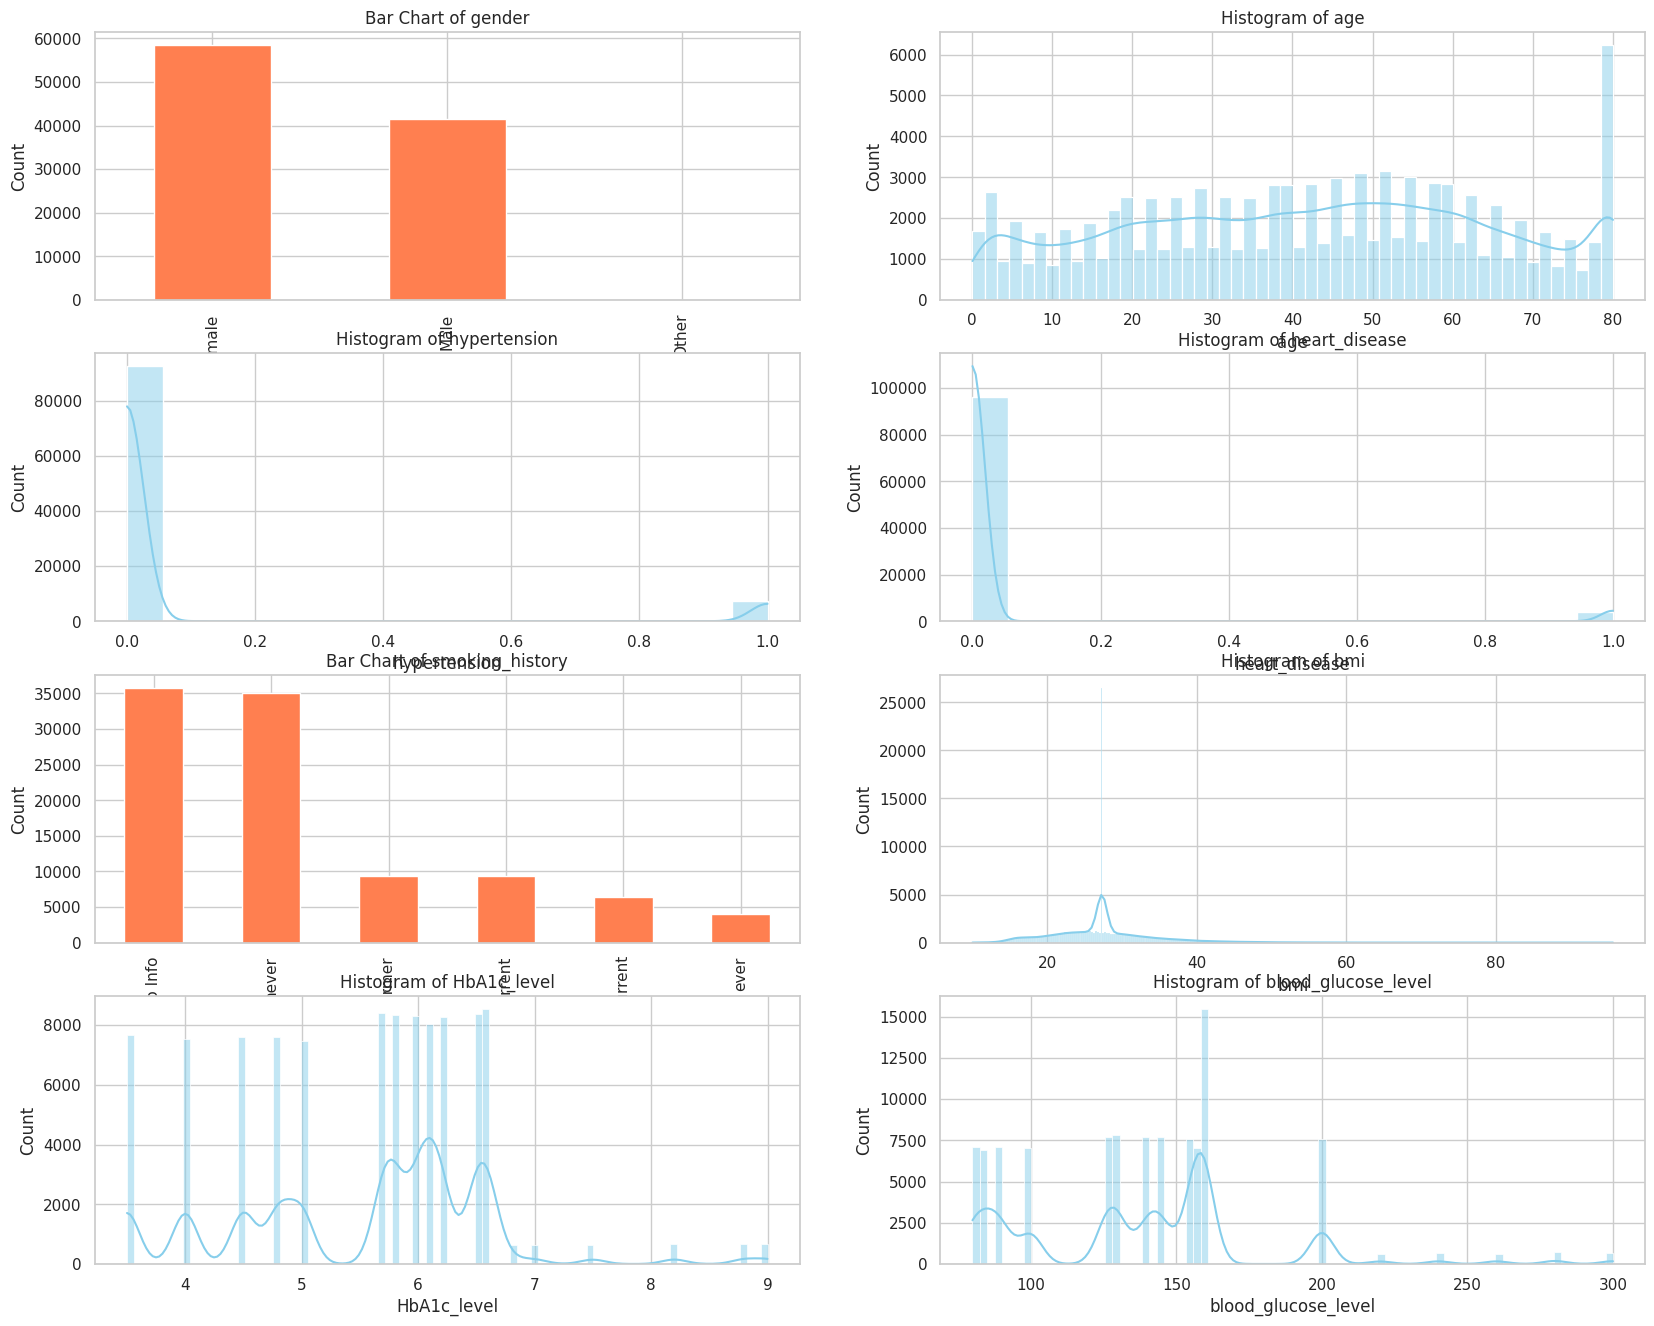

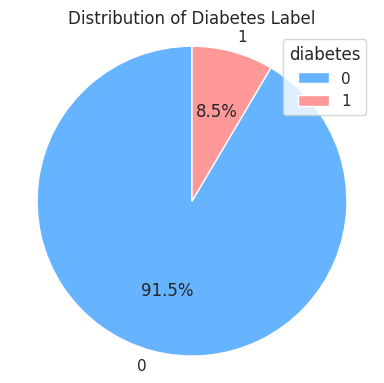

In [9]:
def visualisasiData(df, label_column):
    # Setup tampilan
    sns.set(style="whitegrid")
    n_cols = 2
    cols = df.columns.drop(label_column)
    n_rows = (len(cols) + 1) // n_cols

    plt.figure(figsize=(20, n_rows * 4))

    for idx, col in enumerate(cols):
        plt.subplot(n_rows, n_cols, idx + 1)
        if pd.api.types.is_numeric_dtype(df[col]):
            sns.histplot(df[col], kde=True, color="skyblue")
            plt.title(f'Histogram of {col}')
        else:
            df[col].value_counts().plot(kind='bar', color='coral')
            plt.title(f'Bar Chart of {col}')
            plt.xlabel(col)
            plt.ylabel("Count")

    # Visualisasi pie chart untuk label
    label_counts = df[label_column].value_counts()
    labels = label_counts.index.tolist()
    plt.figure(figsize=(4, 4))
    plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
    plt.title('Distribution of Diabetes Label')
    plt.legend(title=label_column)
    plt.axis('equal')  # Circle pie chart

    plt.tight_layout()
    plt.show()

# Panggil fungsi
visualisasiData(data, 'diabetes')


**Penjelasan :**

Pada visualisasi yang diperoleh terlihat pada distribusi label didominasi dengan kondisi tidak terkena diabetes. Hal ini umum terjadi pada data medis, di mana kondisi tidak terkena penyakit lebih sering dijumpai dibanding dengan kondisi terkena penyakit. Sebaran nilai age itu terlihat bahwa usia didominasi pada responden lansia, dimana frekuensi tertinggi pada usia 80 tahun. Selain itu, responden didominasi pada jenis kelamin laki-laki.

## 3. Data Preparation

### 3.1 Encoding Variabel Kategorik

In [10]:
def preprocessingData(df, kolom, jenis=1, save_dir="Encoder Tersimpan"):
    os.makedirs(save_dir, exist_ok=True)

    if jenis == 1:
        le = LabelEncoder()
        df[kolom] = le.fit_transform(df[kolom])

        # Simpan encoder
        encoder_path = os.path.join(save_dir, f"{kolom}_label_encoder.pkl")
        with open(encoder_path, 'wb') as file:
            pickle.dump(le, file)

        print(f"LabelEncoder untuk '{kolom}' disimpan di: {encoder_path}")

        return df, le
    
    elif jenis == 2:
        df = pd.get_dummies(df, columns=[kolom], prefix=kolom)
        return df, None
    
    else:
        raise ValueError("Parameter 'jenis' harus 1 (Label Encoding) atau 2 (One Hot Encoding)")


data1, encoder_gender = preprocessingData(data, 'gender', 1)
data2, encoder_smokinghist = preprocessingData(data1, 'smoking_history', 2)
data2


LabelEncoder untuk 'gender' disimpan di: Encoder Tersimpan/gender_label_encoder.pkl


,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,80.0,0,1,25.19,6.6,140,0,False,False,False,False,True,False
1,0,54.0,0,0,27.32,6.6,80,0,True,False,False,False,False,False
2,1,28.0,0,0,27.32,5.7,158,0,False,False,False,False,True,False
3,0,36.0,0,0,23.45,5.0,155,0,False,True,False,False,False,False
4,1,76.0,1,1,20.14,4.8,155,0,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,27.32,6.2,90,0,True,False,False,False,False,False
99996,0,2.0,0,0,17.37,6.5,100,0,True,False,False,False,False,False
99997,1,66.0,0,0,27.83,5.7,155,0,False,False,False,True,False,False
99998,0,24.0,0,0,35.42,4.0,100,0,False,False,False,False,True,False


**Penjelasan :**

Berdasarkan perbedaan jenis variabel sebelumnya, dilakukan proses encoding untuk variabel kategorik agar berubah pada tipe numerik. Jenis encoding untuk variabel gender adalah Label Encoder sehingga jenis kelamin akan dinyatakan oleh nilai 0, 1, dan 2. Variabel smoking_history menggunakan encoder berupa One Hot Encoding, sehingga setiap kategori akan dipisahkan menjadi sebanyak 6 kolom yang berisi nilai boolean True (1) atau False (0).

### 3.2 Splitting Data

In [11]:
y = data2["diabetes"]
X = data2.drop(columns=["diabetes"])

# Membagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

# Fit dan transform data training
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

os.makedirs("Encoder Tersimpan", exist_ok=True)
scaler_path = "Encoder Tersimpan/minmax_scaler.pkl"
# Simpan scaler dengan benar
with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)
print(f"Scaler disimpan di: {scaler_path}")


Scaler disimpan di: Encoder Tersimpan/minmax_scaler.pkl


**Penjelasan :**

Didefinisikan y dan X berdasarkan seluruh variabel yang digunakan di awal. Selain itu dilakukan splitting dengan proporsi 80% : 20% menggunakan mekanisme stratify terhadap kategori untuk memperhatikan distribusi label untuk data latih dan data uji. Selanjutnya akan dilakukan normalisasi menggunakan metode MinMaxScaler terhadap data latih dan data uji. 

### 3.3 Resampling

In [12]:
def overSampling(X_train, y_train, rasio):
    # Cek distribusi awal kelas
    print("Distribusi sebelum SMOTE:", Counter(y_train))

    # Inisialisasi SMOTE dengan sampling_strategy 0.5
    smote = SMOTE(sampling_strategy=rasio, random_state=42)

    # Terapkan SMOTE pada data latih
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Cek distribusi setelah resampling
    print("Distribusi setelah SMOTE:", Counter(y_train))
    return X_train, y_train

**Penjelasan :**

Fungsi ini digunakan untuk melakukan proses oversampling sebagai mekanisme mengatasi efek *imbalanced dataset* sehingga model tidak didominasi class mayoritas. Input pada fungsi ini berupa variabel prediktor untuk data latih **(X_train)** dan variabel target pada data latih **(y_train)** serta rasio, dimana **rasio** menyatakan rasio distribusi class minoritas yang ingin ditambahkan.

## 4. Modelling

### 4.1 Modelling dengan KNN yang diikuti Hyperparameter Tuning menggunakan Optuna

In [13]:
def objective_knn(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 10),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2)  # Parameter untuk metrik Minkowski (1=Manhattan, 2=Euclidean)
    }
    
    model = KNeighborsClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    score = balanced_accuracy_score(y_test, y_pred_test)
    return score

study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=10)

# Menampilkan hasil terbaik
print("Best KNN Parameters:", study_knn.best_params)

modelKNN1 = KNeighborsClassifier(**study_knn.best_params)

[I 2025-04-25 14:26:47,164] A new study created in memory with name: no-name-7b2fc735-69b5-480f-a3c8-01a6fae77e51
[I 2025-04-25 14:26:49,388] Trial 0 finished with value: 0.7467470266795243 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.7467470266795243.
[I 2025-04-25 14:26:51,035] Trial 1 finished with value: 0.7710382513661203 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.7710382513661203.
[I 2025-04-25 14:26:52,686] Trial 2 finished with value: 0.7459819993571198 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.7710382513661203.
[I 2025-04-25 14:26:54,688] Trial 3 finished with value: 0.735686274509804 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.7710382513661203.
[I 2025-04-25 14:26:55,660] Trial 4 finished with value: 0.7817341690774671 and parameters: {'n_neighbors': 3, 'weights': 'dis

Best KNN Parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}


### 4.2 Modelling dengan CatBoost Classifier yang diikuti Hyperparameter Tuning menggunakan Optuna

In [14]:
def objective_catboost(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10),
        'random_state': 42,
        'verbose': 0
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    score = balanced_accuracy_score(y_test, y_pred_test)
    return score

study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=10)

print("Best CatBoost Parameters:", study_catboost.best_params)
modelCB1 = CatBoostClassifier(**study_catboost.best_params, random_state=42, verbose=0)

[I 2025-04-25 14:27:04,626] A new study created in memory with name: no-name-1d705e55-097f-4c6d-9084-e736f7ee2ff0


[I 2025-04-25 14:27:16,249] Trial 0 finished with value: 0.8463773706203792 and parameters: {'depth': 5, 'learning_rate': 0.10806161395625372, 'iterations': 997, 'border_count': 75, 'bagging_temperature': 0.9555645707902085, 'l2_leaf_reg': 8.880656653129167}. Best is trial 0 with value: 0.8463773706203792.
[I 2025-04-25 14:27:18,669] Trial 1 finished with value: 0.8413821922211507 and parameters: {'depth': 5, 'learning_rate': 0.02093019808621644, 'iterations': 226, 'border_count': 220, 'bagging_temperature': 0.9261323997975665, 'l2_leaf_reg': 9.752786650953258}. Best is trial 0 with value: 0.8463773706203792.
[I 2025-04-25 14:27:23,149] Trial 2 finished with value: 0.8426615236258438 and parameters: {'depth': 4, 'learning_rate': 0.017574817160476118, 'iterations': 501, 'border_count': 59, 'bagging_temperature': 0.6794880959586284, 'l2_leaf_reg': 3.0185334306809066}. Best is trial 0 with value: 0.8463773706203792.
[I 2025-04-25 14:27:39,616] Trial 3 finished with value: 0.85122147219543

Best CatBoost Parameters: {'depth': 9, 'learning_rate': 0.23318511591740917, 'iterations': 926, 'border_count': 99, 'bagging_temperature': 0.5500581986623337, 'l2_leaf_reg': 6.570372884152365}


**Penjelasan :**

Tahapan selanjutnya adalah pemodelan yang dilakukan menggunakan algoritma KNN dan CatBoost. Dalam menentukan hyperparameter yang dapat mengoptimalkan kedua algoritma, digunakan library optuna yang menerapkan **Algoritma Tree Parzen Structure** untuk melakukan pencarian hyperparameter atau dikenal dengan *hyperparameter tuning* untuk algoritma KNN dan CatBoost.

## 5. Evaluation

### 5.1 Pendefinisian Fungsi Evaluasi dan Visualisasi Performa Model

In [15]:
def evaluasiModel(judul, model, X_train, y_train, X_test, y_test, save_dir="Model Tersimpan"):
    print(judul)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    # Evaluasi metrik
    bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    acc = accuracy_score(y_test, y_test_pred)

    # Cek apakah model mendukung predict_proba atau decision_function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = None

    # Hitung AUC jika memungkinkan
    auc_score = roc_auc_score(y_test, y_score) if y_score is not None else None

    print("Final Balanced Accuracy pada Data Uji :", bal_acc)
    print("F1 Score (Macro) : ", f1_macro)
    print("Accuracy : ", acc)
    if auc_score is not None:
        print("AUC Score:", auc_score)
    else:
        print("AUC Score: Tidak tersedia")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Pred 0', 'Pred 1'], 
                yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Simpan model
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{judul.replace(' ', '_')}.pkl")
    # Simpan model dengan benar
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model disimpan di: {model_path}")

    return {
        "Skenario": judul,
        "Balanced Accuracy": bal_acc,
        "F1 Score (Macro)": f1_macro,
        "Accuracy": acc,
        "AUC": auc_score,
        "Model Path": model_path
    }


**Penjelasan :**

Fungsi ini bertujuan untuk melakukan evaluasi terhadap model machine learning yang dibangun. Terdapat 6 inputan judul, model, X_train, y_train, X_test, dan y_test. Kode ini bertujuan untuk menghasilkan ukuran evaluasi berupa Balanced Accuracy, Classification Report, ROC-AUC, dan Confusion Matrix. 

### 5.2 Evaluasi Model Klasifikasi

====== Evaluasi Model KNN ======
Final Balanced Accuracy pada Data Uji : 0.7817341690774671
F1 Score (Macro) :  0.8184115977980813
Accuracy :  0.95015
AUC Score: 0.855479331404693

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     18300
           1       0.78      0.58      0.66      1700

    accuracy                           0.95     20000
   macro avg       0.87      0.78      0.82     20000
weighted avg       0.95      0.95      0.95     20000



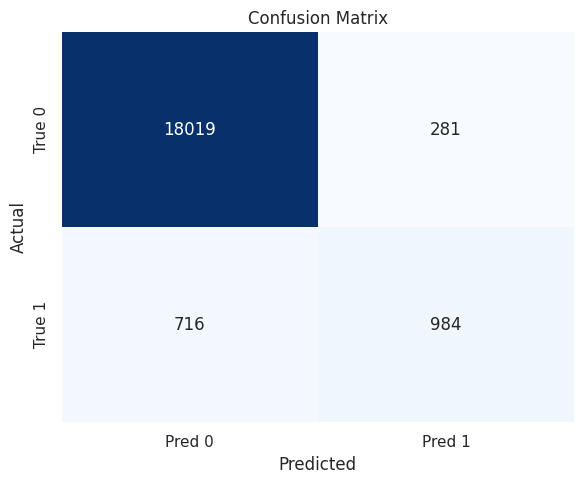

Model disimpan di: Model Tersimpan/======_Evaluasi_Model_KNN_======.pkl
====== Evaluasi Model Catboost ======
Final Balanced Accuracy pada Data Uji : 0.8540758598521376
F1 Score (Macro) :  0.8868003554468838
Accuracy :  0.9678
AUC Score: 0.9699973802635808

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.88      0.72      0.79      1700

    accuracy                           0.97     20000
   macro avg       0.93      0.85      0.89     20000
weighted avg       0.97      0.97      0.97     20000



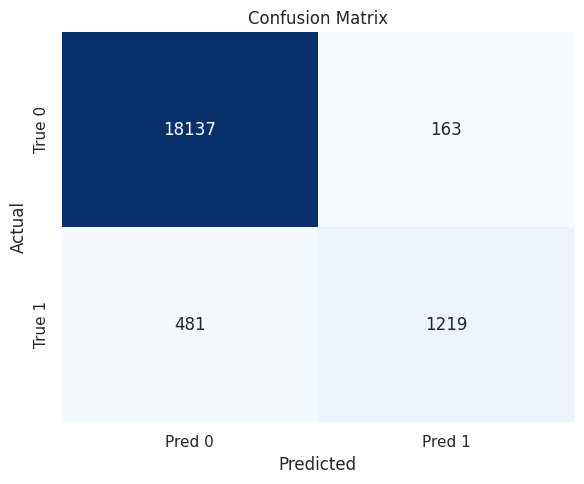

Model disimpan di: Model Tersimpan/======_Evaluasi_Model_Catboost_======.pkl


In [16]:
hasil1 = evaluasiModel("====== Evaluasi Model KNN ======", modelKNN1, X_train, y_train, X_test, y_test)
hasil2 = evaluasiModel("====== Evaluasi Model Catboost ======",modelCB1, X_train, y_train, X_test, y_test)

**Penjelasan :**

Berdasarkan pelatihan yang dilakukan terlihat bahwa model yang dibangun sudah cukup baik, di mana nilai akurasi berada di nilai > 95%. Pada hasil pencarian optuna untuk kedua algoritma diperoleh hyperparameter terbaik adalah sebagai berikut.

***Model KNN = {'n_neighbors': 4, 'weights': 'distance', 'p': 2}*** <br>

***Model CatBoost = {'depth': 6, 'learning_rate': 0.29798686982981326, 'iterations': 658, 'border_count': 35, 'bagging_temperature': 0.9411272092315249, 'l2_leaf_reg': 6.648574264486246}***

Namun, pada nilai F-1 Score Macro dan Balanced Accuracy yang cenderung lebih tepat digunakan untuk mengukur performa model klasifikasi pada kondisi imbalanced dataset, terlihat bahwa nilai Balanced Accuracy dan F-1 Score Macro pada model CatBoost lebih tinggi dibanding KNN secara berturut-turut adalah 85 dan 89. Hal ini menunjukkan model CatBoost lebih baik dalam memprediksi pada kedua class. 

### 5.3 Pemberian perlakuan resampling dengan SMOTE untuk mengatasi efek *imbalanced dataset*

In [17]:
X_train, y_train = overSampling(X_train, y_train, 0.5)

print("========== KNN dengan SMOTE ==========")
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=10)

# Menampilkan hasil terbaik
print("Best KNN Parameters:", study_knn.best_params)

modelKNN2 = KNeighborsClassifier(**study_knn.best_params)

print("========== CatBoost dengan SMOTE ==========")
study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=10)

print("Best CatBoost Parameters:", study_catboost.best_params)
modelCB2 = CatBoostClassifier(**study_catboost.best_params, random_state=42, verbose=0)

Distribusi sebelum SMOTE: Counter({0: 73200, 1: 6800})


/home/anugerahsurya/.local/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/anugerahsurya/.local/lib/python3.10/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
[I 2025-04-25 14:29:06,489] A new study created in memory with name: no-name-23c5b47c-5553-4a91-b307-ecd7baf231f2


Distribusi setelah SMOTE: Counter({0: 73200, 1: 36600})
========== KNN dengan SMOTE ==========


[I 2025-04-25 14:29:07,809] Trial 0 finished with value: 0.8221648987463839 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.8221648987463839.
[I 2025-04-25 14:29:09,601] Trial 1 finished with value: 0.8098923175827708 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.8221648987463839.
[I 2025-04-25 14:29:12,239] Trial 2 finished with value: 0.7949341047894567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.8221648987463839.
[I 2025-04-25 14:29:14,141] Trial 3 finished with value: 0.8161796849887496 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.8221648987463839.
[I 2025-04-25 14:29:16,129] Trial 4 finished with value: 0.8282963677274189 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'p': 2}. Best is trial 4 with value: 0.8282963677274189.
[I 2025-04-25 14:29:17,445] Trial 5 finished wi

Best KNN Parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}
========== CatBoost dengan SMOTE ==========


[I 2025-04-25 14:29:38,072] Trial 0 finished with value: 0.8484297653487625 and parameters: {'depth': 5, 'learning_rate': 0.138105444091759, 'iterations': 944, 'border_count': 225, 'bagging_temperature': 0.8032491094502433, 'l2_leaf_reg': 4.327132182705367}. Best is trial 0 with value: 0.8484297653487625.
[I 2025-04-25 14:29:51,864] Trial 1 finished with value: 0.8460961105753777 and parameters: {'depth': 7, 'learning_rate': 0.036144428448795715, 'iterations': 824, 'border_count': 217, 'bagging_temperature': 0.9542326585660138, 'l2_leaf_reg': 8.159001679274935}. Best is trial 0 with value: 0.8484297653487625.
[I 2025-04-25 14:30:07,377] Trial 2 finished with value: 0.8489022822243651 and parameters: {'depth': 9, 'learning_rate': 0.11255195117270887, 'iterations': 490, 'border_count': 81, 'bagging_temperature': 0.928909992116531, 'l2_leaf_reg': 6.8143945232017185}. Best is trial 2 with value: 0.8489022822243651.
[I 2025-04-25 14:30:16,995] Trial 3 finished with value: 0.8525409836065574

Best CatBoost Parameters: {'depth': 4, 'learning_rate': 0.29937529311170064, 'iterations': 879, 'border_count': 220, 'bagging_temperature': 0.32996767322674414, 'l2_leaf_reg': 2.2683208191054964}


### 5.4 Evaluasi Hasil Perlakuan Resampling pada Algoritma KNN dan Catboost

====== Evaluasi Model KNN-SMOTE ======
Final Balanced Accuracy pada Data Uji : 0.8379861780777885
F1 Score (Macro) :  0.7932513069208496
Accuracy :  0.92615
AUC Score: 0.9205247990999679

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     18300
           1       0.55      0.73      0.63      1700

    accuracy                           0.93     20000
   macro avg       0.76      0.84      0.79     20000
weighted avg       0.94      0.93      0.93     20000



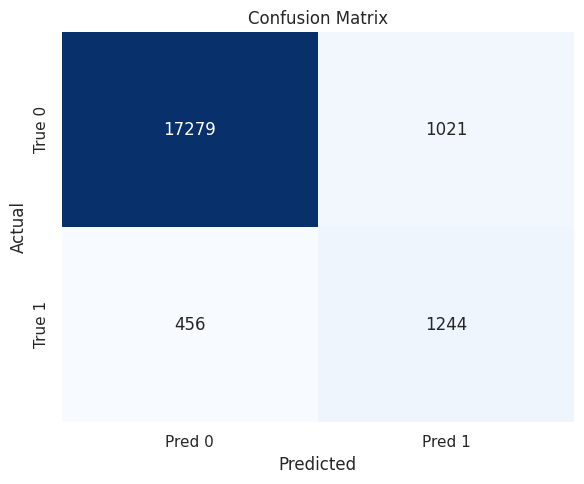

Model disimpan di: Model Tersimpan/======_Evaluasi_Model_KNN-SMOTE_======.pkl
====== Evaluasi Model CatBoost-SMOTE ======
Final Balanced Accuracy pada Data Uji : 0.8525409836065574
F1 Score (Macro) :  0.8948583297600043
Accuracy :  0.97085
AUC Score: 0.9758195274831245

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.93      0.71      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.95      0.85      0.89     20000
weighted avg       0.97      0.97      0.97     20000



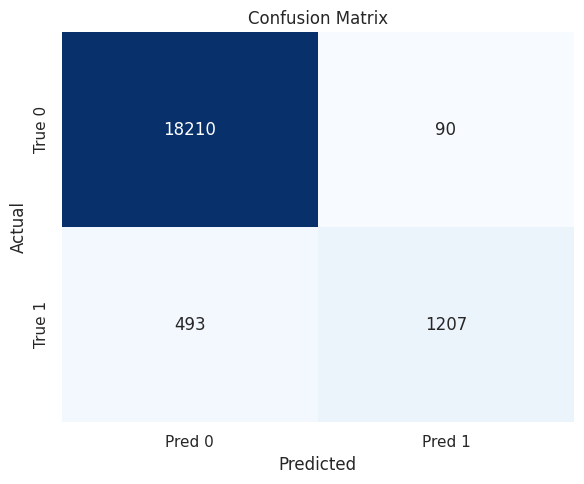

Model disimpan di: Model Tersimpan/======_Evaluasi_Model_CatBoost-SMOTE_======.pkl


In [18]:
hasil3 = evaluasiModel("====== Evaluasi Model KNN-SMOTE ======", modelKNN2, X_train, y_train, X_test, y_test)
hasil4 = evaluasiModel("====== Evaluasi Model CatBoost-SMOTE ======",modelCB2, X_train, y_train, X_test, y_test)

### 5.5 Final Evaluasi Model

In [19]:
df_hasil = pd.DataFrame([hasil1, hasil2, hasil3, hasil4])
df_hasil

,Skenario,Balanced Accuracy,F1 Score (Macro),Accuracy,AUC,Model Path
0,====== Evaluasi Model KNN ======,0.781734,0.818412,0.95015,0.855479,Model Tersimpan/======_Evaluasi_Model_KNN_====...
1,====== Evaluasi Model Catboost ======,0.854076,0.886800,0.96780,0.969997,Model Tersimpan/======_Evaluasi_Model_Catboost...
2,====== Evaluasi Model KNN-SMOTE ======,0.837986,0.793251,0.92615,0.920525,Model Tersimpan/======_Evaluasi_Model_KNN-SMOT...
3,====== Evaluasi Model CatBoost-SMOTE ======,0.852541,0.894858,0.97085,0.975820,Model Tersimpan/======_Evaluasi_Model_CatBoost...


**Penjelasan :**

Berdasarkan hasil evaluasi pada keempat skenario yang diujikan terlihat bahwa penerapan teknik oversampling pada algoritma KNN berhasil meningkatkan balanced accuracy dan AUC pada model KNN namun menurunkan ukuran evaluasi F1-Score Macro dan Accuracy pada moodel tersebut. Namun, kondisi berbeda ditunjukkan oleh algoritma CatBoost, dimana tidak terdapat peningkatan hasil setelah SMOTE, bahkan terdapat penurunan performa, walaupun tidak signifikan. 

Berdasarkan analisis ini dapat disimpulkan penerapan teknik oversampling secara umum tidak memberikan peningkatan performa yang signifikan pada model yang digunakan. Selain itu model yang dibangun sudah cukup mengklasifikasikan data dengan baik, sehingga dapat diimplementasikan dalam pembuatan model prediksi diabetes.